In [1]:
!pip install --verbose --no-cache-dir torch-sparse
!pip install --verbose --no-cache-dir torch-scatter
!pip install --verbose --no-cache-dir torch-cluster
!pip install torch-geometric

Created temporary directory: /tmp/pip-ephem-wheel-cache-z8xuht28
Created temporary directory: /tmp/pip-req-tracker-noudl2xs
Created requirements tracker '/tmp/pip-req-tracker-noudl2xs'
Created temporary directory: /tmp/pip-install-5pp512wq
1 location(s) to search for versions of torch-sparse:
* https://pypi.org/simple/torch-sparse/
Getting page https://pypi.org/simple/torch-sparse/
Found index url https://pypi.org/simple
Starting new HTTPS connection (1): pypi.org:443
https://pypi.org:443 "GET /simple/torch-sparse/ HTTP/1.1" 200 1096
Analyzing links from page https://pypi.org/simple/torch-sparse/
  Found link https://files.pythonhosted.org/packages/21/a6/af5865f7bc2dc45ea789ebb35bdf5d84c05e140d7d2ec7e5823d24db176f/torch_sparse-0.1.0.tar.gz#sha256=d774c4b05a96bf09e3c3becd2f48c65ed66b03195a2cfc4992ef57c9a8c6b399 (from https://pypi.org/simple/torch-sparse/), version: 0.1.0
  Found link https://files.pythonhosted.org/packages/02/4f/89bcb156022a3960c4db852915c64ea78b4e993e0f8d7a83e60e6819fc

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torch_geometric as gnn
from torch_cluster import knn_graph
import torchvision
from torchvision import transforms

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import os
cifar100_root = './cifar100_data'
# os.mkdir(cifar100_root)

# knn_graph test

In [0]:
a = torch.rand((4,5,7))
b = torch.rand((4,5,7))
c = torch.rand((4,5,7))
x = torch.stack([a,b,c], dim=0)
size = x.shape

In [58]:
x[0][:2]

tensor([[[0.3343, 0.1169, 0.9806, 0.6534, 0.2318, 0.8633, 0.5106],
         [0.9462, 0.3668, 0.2004, 0.8090, 0.1139, 0.6972, 0.5718],
         [0.0298, 0.5342, 0.5593, 0.1070, 0.9415, 0.0524, 0.6681],
         [0.0461, 0.3465, 0.3979, 0.5476, 0.3109, 0.2710, 0.3456],
         [0.2732, 0.0529, 0.4193, 0.9354, 0.8605, 0.5772, 0.1359]],

        [[0.3560, 0.6823, 0.6633, 0.4856, 0.3114, 0.6565, 0.8925],
         [0.1850, 0.6882, 0.4687, 0.9186, 0.1537, 0.4641, 0.5011],
         [0.7730, 0.5176, 0.3368, 0.4651, 0.8551, 0.4214, 0.2188],
         [0.4245, 0.6978, 0.0775, 0.6541, 0.8511, 0.4366, 0.7573],
         [0.4870, 0.3371, 0.4677, 0.7668, 0.2573, 0.8279, 0.5768]]])

In [59]:
a[:,0,0]

tensor([0.3343, 0.3560, 0.0266, 0.6398])

In [60]:
x = x.permute(0,2,3,1)
x = x.reshape(-1,x.size()[-1])
x[0]

tensor([0.3343, 0.3560, 0.0266, 0.6398])

In [61]:
batch = torch.tensor([[batch for j in range(size[2]*size[3])] for batch in [i for i in range(size[0])]])
batch = batch.view(-1)
edge_index = knn_graph(x, k=2, batch=batch, loop=False, flow='target_to_source')
edge_index[:5, :5]

tensor([[ 0,  0,  1,  1,  2],
        [ 4,  9, 14, 21,  5]])

In [62]:
x = x.reshape(size[0], size[2], size[3], size[1])
x = x.permute(0, 3, 1, 2)
x[0][0:2]

tensor([[[0.3343, 0.1169, 0.9806, 0.6534, 0.2318, 0.8633, 0.5106],
         [0.9462, 0.3668, 0.2004, 0.8090, 0.1139, 0.6972, 0.5718],
         [0.0298, 0.5342, 0.5593, 0.1070, 0.9415, 0.0524, 0.6681],
         [0.0461, 0.3465, 0.3979, 0.5476, 0.3109, 0.2710, 0.3456],
         [0.2732, 0.0529, 0.4193, 0.9354, 0.8605, 0.5772, 0.1359]],

        [[0.3560, 0.6823, 0.6633, 0.4856, 0.3114, 0.6565, 0.8925],
         [0.1850, 0.6882, 0.4687, 0.9186, 0.1537, 0.4641, 0.5011],
         [0.7730, 0.5176, 0.3368, 0.4651, 0.8551, 0.4214, 0.2188],
         [0.4245, 0.6978, 0.0775, 0.6541, 0.8511, 0.4366, 0.7573],
         [0.4870, 0.3371, 0.4677, 0.7668, 0.2573, 0.8279, 0.5768]]])

# **GC layer implementation**

In [0]:
class GC_layer(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, hidden_layers=1):
        super(GC_layer, self).__init__()
        self.out_channels = out_channels

        edge_modules = []
        edge_modules.append(nn.Linear(in_channels, hidden_channels))
        # edge_modules.append(nn.BatchNorm1d(hidden_channels))
        edge_modules.append(nn.ReLU())
        for i in range(hidden_layers-1):
            edge_modules.append(nn.Linear(hidden_channels, hidden_channels))
            # edge_modules.append(nn.BatchNorm1d(hidden_channels))
            edge_modules.append(nn.ReLU())
        edge_modules.append(nn.Linear(hidden_channels, in_channels * out_channels))
        # edge_modules.append(nn.BatchNorm1d(in_channels * out_channels))
        edge_modules.append(nn.ReLU())
        edge_net = nn.Sequential(*edge_modules)

        self.conv1x1 = nn.Conv2d(in_channels, out_channels, (1,1), padding=0)
        self.conv3x3 = nn.Conv2d(in_channels, out_channels, (3,3), padding=1)
        self.gconv = gnn.nn.ECConv(in_channels, out_channels, edge_net)

    def forward(self, x, edge_index, edge_attr):
        x_conv1x1 = self.conv1x1(x)
        x_conv3x3 = self.conv3x3(x)

        sizes = x.size()
        x = x.permute(0,2,3,1)
        x = x.reshape(-1,x.size()[-1])
        x_gconv = self.gconv(x, edge_index, edge_attr)

        x_gconv = x_gconv.reshape(sizes[0], sizes[2], sizes[3], self.out_channels)
        x_gconv = x_gconv.permute(0, 3, 1, 2)

        return torch.mean(torch.stack([x_conv1x1, x_conv3x3, x_gconv]), axis=0)


# Check GC_Layer

## cpu

In [70]:
x = torch.rand(16,3,32,32)
sizes = x.size()
x = x.permute(0,2,3,1)
x = x.reshape(-1,x.size()[-1])

batch = torch.tensor([[batch for j in range(sizes[2]*sizes[3])] for batch in [i for i in range(sizes[0])]]).view(-1)
edge_index = knn_graph(x, k=8, batch=batch, loop=False, flow='source_to_target')
edge_index_t = edge_index.t()  # ?
edge_attr = x[edge_index_t[:,1]] - x[edge_index_t[:,0]]

x = x.reshape(sizes[0], sizes[2], sizes[3], sizes[1])
x = x.permute(0, 3, 1, 2)

g = GC_layer(3, 9, 3)
g(x, edge_index, edge_attr).size()

torch.Size([16, 9, 32, 32])

## cuda

In [183]:
x = torch.rand(16,3,32,32).cuda()
sizes = x.size()
x = x.permute(0,2,3,1)
x = x.reshape(-1,x.size()[-1])

batch = torch.tensor([[batch for j in range(sizes[2]*sizes[3])] for batch in [i for i in range(sizes[0])]]).view(-1).cuda()
edge_index = knn_graph(x, k=8, batch=batch, loop=False, flow='source_to_target')
edge_index_t = edge_index.t()  # ?
edge_attr = x[edge_index_t[:,1]] - x[edge_index_t[:,0]]

x = x.reshape(sizes[0], sizes[2], sizes[3], sizes[1])
x = x.permute(0, 3, 1, 2)

g = GC_layer(3, 9, 3).cuda()
g(x, edge_index, edge_attr).size()

torch.Size([16, 9, 32, 32])

# **Preprocessing Block implementation**

In [0]:
class Preproc_block_path(nn.Module):
    def __init__(self, conv_in_channels, conv_out_channels, kernel, hidden_channels, hidden_layers, 
                 gconv_out_channels, k_nearest, flow, lrelu_slope):
        super(Preproc_block_path, self).__init__()
        self.k = k_nearest
        self.flow = flow
        self.lrelu_slope = lrelu_slope

        self.conv = nn.Conv2d(conv_in_channels, conv_out_channels, kernel, padding=kernel//2)
        self.gc = GC_layer(conv_out_channels, gconv_out_channels, hidden_channels)
        self.bn = nn.BatchNorm2d(gconv_out_channels)

    def forward(self, x):
        x = F.leaky_relu(self.conv(x), self.lrelu_slope)

        sizes = x.size()
        x = x.permute(0,2,3,1)
        x = x.reshape(-1,x.size()[-1])

        batch = torch.tensor([[batch for j in range(sizes[2]*sizes[3])] for batch in [i for i in range(sizes[0])]]).view(-1)
        if x.is_cuda:
            batch = batch.cuda()
        edge_index = knn_graph(x, k=self.k, batch=batch, loop=False, flow=self.flow)
        edge_index_t = edge_index.t()  # ?
        edge_attr = x[edge_index_t[:,1]] - x[edge_index_t[:,0]]

        x = x.reshape(sizes[0], sizes[2], sizes[3], sizes[1])
        x = x.permute(0, 3, 1, 2)
        x = self.gc(x, edge_index, edge_attr)
        
        x = F.leaky_relu(self.bn(x), self.lrelu_slope)
        return x


class Preprocessing_block(nn.Module):
    def __init__(self, conv_in_channels=3, conv_out_channels=3, kernels=[3,5,7], hidden_channels=3, hidden_layers=1, 
                 gconv_out_channels=3, k_nearest=8, flow='source_to_target', lrelu_slope=0.01, device='cuda'):
        super(Preprocessing_block, self).__init__()

        self.preproc_paths = []
        for kernel in kernels:
            self.preproc_paths.append(Preproc_block_path(conv_in_channels, conv_out_channels, 
                                                    kernel, hidden_channels, hidden_layers, 
                                                    gconv_out_channels, k_nearest, flow, lrelu_slope).to(device))

    def forward(self, x):
        x_lst = []
        for path in self.preproc_paths:
            x_lst.append(path(x))
        return torch.cat(x_lst, dim=1)

# Check Preprocessing_block

## cpu

In [208]:
x = torch.rand(16,3,32,32)
sizes = x.size()

g = Preprocessing_block(device='cpu')
x = g(x)
x.size()

torch.Size([16, 9, 32, 32])

## cuda

In [204]:
x = torch.rand(16,3,32,32).cuda()
sizes = x.size()

g = Preprocessing_block(device='cuda')
x = g(x)
x.size()

torch.Size([16, 9, 32, 32])

# **Residual Block implemetation**

In [0]:
class Residual_block(nn.Module):

    def __init__(self, gconv_in_channels=9, gconv_out_channels=9, hidden_channels=9, hidden_layers=1, k_nearest=8, flow='source_to_target', lrelu_slope=0.01):
        super(Residual_block, self).__init__()
        self.k = k_nearest
        self.flow = flow
        self.lrelu_slope = lrelu_slope

        self.gc1 = GC_layer(gconv_in_channels, gconv_out_channels, hidden_channels, hidden_layers)
        self.bn1 = nn.BatchNorm2d(gconv_out_channels)

        self.gc2 = GC_layer(gconv_in_channels, gconv_out_channels, hidden_channels, hidden_layers)
        self.bn2 = nn.BatchNorm2d(gconv_out_channels)

        self.gc3 = GC_layer(gconv_in_channels, gconv_out_channels, hidden_channels, hidden_layers)
        self.bn3 = nn.BatchNorm2d(gconv_out_channels)

    def forward(self, x):

        sizes = x.size()
        x = x.permute(0,2,3,1)
        x = x.reshape(-1,x.size()[-1])

        batch = torch.tensor([[batch for j in range(sizes[2]*sizes[3])] for batch in [i for i in range(sizes[0])]]).view(-1)
        if x.is_cuda:
            batch = batch.cuda()
        edge_index = knn_graph(x, k=self.k, batch=batch, loop=False, flow=self.flow)
        edge_index_t = edge_index.t()  # ?
        edge_attr = x[edge_index_t[:,1]] - x[edge_index_t[:,0]]

        x = x.reshape(sizes[0], sizes[2], sizes[3], sizes[1])
        x = x.permute(0, 3, 1, 2)
        
        x_res = F.leaky_relu(self.bn1(self.gc1(x, edge_index, edge_attr)), self.lrelu_slope)
        x_res = F.leaky_relu(self.bn2(self.gc2(x_res, edge_index, edge_attr)), self.lrelu_slope)
        x_res = F.leaky_relu(self.bn3(self.gc3(x_res, edge_index, edge_attr)), self.lrelu_slope)

        return x+x_res

# Check Residual block

## cpu

In [209]:
g = Residual_block()
g(x).size()

torch.Size([16, 9, 32, 32])

## cuda

In [207]:
g = Residual_block().cuda()
g(x).size()

torch.Size([16, 9, 32, 32])

# **GraphCNN denoiser implementation**

In [0]:
class GraphCNN_denoiser(nn.Module):

    def __init__(self, preproc_conv_in_channels=3, preproc_conv_out_channels=3, preproc_gconv_out_channels=3,
                 preproc_hidden_channels=3, preproc_hidden_layers=1, 
                 residual_gconv_in_channels=9, residual_gconv_out_channels=9,
                 residual_hidden_channels=9, residual_hidden_layers=1,
                 k_nearest=8, lrelu_slope=0.01, flow='source_to_target', device='cuda', **kwargs):
        super(GraphCNN_denoiser, self).__init__()
        self.k=k_nearest
        self.flow = flow

        self.preproc = Preprocessing_block(conv_in_channels=preproc_conv_in_channels,
                                           conv_out_channels=preproc_conv_out_channels, 
                                           gconv_out_channels=preproc_gconv_out_channels,
                                           hidden_channels=preproc_hidden_channels,
                                           hidden_layers=preproc_hidden_layers,
                                           k_nearest=k_nearest, lrelu_slope=lrelu_slope, device=device).to(device)
        self.residual_1 = Residual_block(gconv_in_channels=residual_gconv_in_channels,
                                         gconv_out_channels=residual_gconv_out_channels,
                                         hidden_channels=residual_hidden_channels,
                                         hidden_layers=residual_hidden_layers,
                                         k_nearest=k_nearest, lrelu_slope=lrelu_slope).to(device)
        self.residual_2 = Residual_block(gconv_in_channels=residual_gconv_in_channels,
                                         gconv_out_channels=residual_gconv_out_channels,
                                         hidden_channels=residual_hidden_channels,
                                         hidden_layers=residual_hidden_layers,
                                         k_nearest=k_nearest, lrelu_slope=lrelu_slope).to(device)
        self.gc = GC_layer(in_channels=residual_gconv_out_channels, out_channels=3, hidden_channels=residual_hidden_channels).to(device)

    def forward(self, x):
        x_dn = self.preproc(x)
        x_dn = self.residual_1(x_dn)
        x_dn = self.residual_2(x_dn)

        sizes = x_dn.size()
        x_dn = x_dn.permute(0,2,3,1)
        x_dn = x_dn.reshape(-1, x_dn.size()[-1])

        batch = torch.tensor([[batch for j in range(sizes[2]*sizes[3])] for batch in [i for i in range(sizes[0])]]).view(-1)
        if x.is_cuda:
            batch = batch.cuda()
        edge_index = knn_graph(x_dn, k=self.k, batch=batch, loop=False, flow=self.flow)
        edge_index_t = edge_index.t()  # ?
        edge_attr = x_dn[edge_index_t[:,1]] - x_dn[edge_index_t[:,0]]

        x_dn = x_dn.reshape(sizes[0], sizes[2], sizes[3], sizes[1])
        x_dn = x_dn.permute(0, 3, 1, 2)
        x_dn = self.gc(x_dn, edge_index, edge_attr)


        return x + x_dn

# Check GraphCNN_denoise

## cpu

In [14]:
x = torch.rand(16,3,32,32)

g = GraphCNN_denoiser(preproc_conv_out_channels=8, preproc_gconv_out_channels=8, 
                      preproc_hidden_channels=16, preproc_hidden_layers=2, 
                      residual_gconv_in_channels=24, residual_gconv_out_channels=24,
                      residual_hidden_channels=24, residual_hidden_layers=2,
                      device='cpu')
x = g(x)
x.size()

torch.Size([16, 3, 32, 32])

## cuda

In [227]:
x = torch.rand(16,3,32,32).cuda()

g = GraphCNN_denoiser(device='cuda')
x = g(x)
x.size()

torch.Size([16, 3, 32, 32])

In [0]:
train = torchvision.datasets.CIFAR100(cifar100_root, train=True, transform=None, target_transform=None, download=False)
test = torchvision.datasets.CIFAR100(cifar100_root, train=False, transform=None, target_transform=None, download=False)

In [0]:
class Cifar100_dataset(Dataset):
    
    def __init__(self, data, noise_mean, noise_mult, transform=None):
        self.data = data.data
        self.targets = data.targets
        self.transform = transform
        self.noise_mult = noise_mult
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        x = self.data[idx]
        t = self.targets[idx]
        
        noise = torch.rand(x.shape[2], x.shape[0], x.shape[1])*self.noise_mult
        if self.transform:
            x = transform(x)
        x_noise = x + noise
        x_noise = torch.clamp(x_noise, 0, 1)
        
        return x, x_noise, t

In [0]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])


cifar100_train_data = Cifar100_dataset(train, 0, 0.25, transform)
cifar100_train_iterator = DataLoader(cifar100_train_data, batch_size=24, shuffle=True)

cifar100_test_data = Cifar100_dataset(test, 0, 0.25, transform)
cifar100_test_iterator = DataLoader(cifar100_test_data, batch_size=24, shuffle=True)

In [0]:
def evaluation(model, iterator, losses_batch, get_preds=False):
    
    model.eval()
    losses = []
    imgs_clean = np.zeros((1,3,32,32))
    imgs_true = np.zeros((1,3,32,32))
    imgs_noised = np.zeros((1,3,32,32))
    
    for batch_index, (img_true, img_noised, labels) in enumerate(iterator):
        img_noised = img_noised.cuda()
        img_true = img_true.cuda()

        outputs = model(img_noised)
        loss = loss_function(img_true, outputs)
        losses.append(loss.item())
        
        if get_preds:
            img = images.cpu().numpy()
            imgs_clean = np.vstack((imgs_clean, outputs.detach().cpu().numpy()))
            imgs_true = np.vstack((imgs_true, img_true.cpu().numpy()))
            imgs_noised = np.vstack((imgs_noised, img_noised.cpu().numpy()))
        
    losses_batch['eval'].append(np.mean(losses))
    print(losses_batch['eval'][-1])
    
    if get_preds:
        return imgs_true, imgs_clean, imgs_noised

In [11]:
model = GraphCNN_denoiser(preproc_conv_out_channels=8, preproc_gconv_out_channels=8, 
                      preproc_hidden_channels=16, preproc_hidden_layers=2, 
                      residual_gconv_in_channels=24, residual_gconv_out_channels=24,
                      residual_hidden_channels=24, residual_hidden_layers=2,
                      device='cuda', k_nearest=8, lrelu_slope=0.1, flow='source_to_target')

model.train()

optimizer = optim.Adam(model.parameters())
loss_function = nn.MSELoss()

eval_iter = 500
n_epoch = 3
losses_batch = {'train': [], 'eval': []}

for epoch in range(n_epoch):
    print(f'Train ---- Epoch_{epoch}')
    for batch_index, (img_true, img_noised, labels) in enumerate(cifar100_train_iterator):
        optimizer.zero_grad()
        img_noised = img_noised.cuda()
        img_true = img_true.cuda()
        
        outputs = model(img_noised)
        loss = loss_function(img_true, outputs)
        loss.backward()
        optimizer.step()

        losses_batch['train'].append(loss.item())

        if batch_index%eval_iter == 0 and batch_index != 0:

            print(f'Evaluation (batch_{batch_index}) = ', end='')
            evaluation(model, cifar100_test_iterator, losses_batch)
            
            model.train()

Train ---- Epoch_0
Evaluation (batch_500) = 0.057911529216906434
Evaluation (batch_1000) = 0.025003504615536125
Evaluation (batch_1500) = 0.01597135479403414
Evaluation (batch_2000) = 0.011846615059627332
Train ---- Epoch_1
Evaluation (batch_500) = 0.009230670468921927
Evaluation (batch_1000) = 0.007732993134741874
Evaluation (batch_1500) = 0.006744756160094012
Evaluation (batch_2000) = 0.00612829875634264
Train ---- Epoch_2
Evaluation (batch_500) = 0.005520079673515807
Evaluation (batch_1000) = 0.005026040657934883
Evaluation (batch_1500) = 0.004744189252018285
Evaluation (batch_2000) = 0.004709319208192525


In [13]:
model.train()
eval_iter = 500
n_epoch = 1
losses_batch = {'train': [], 'eval': []}

for epoch in range(n_epoch):
    print(f'Train ---- Epoch_{epoch}')
    for batch_index, (img_true, img_noised, labels) in enumerate(cifar100_train_iterator):
        optimizer.zero_grad()
        img_noised = img_noised.cuda()
        img_true = img_true.cuda()
        
        outputs = model(img_noised)
        loss = loss_function(img_true, outputs)
        loss.backward()
        optimizer.step()

        losses_batch['train'].append(loss.item())

        if batch_index%eval_iter == 0 and batch_index != 0:

            print(f'Evaluation (batch_{batch_index}) = ', end='')
            evaluation(model, cifar100_test_iterator, losses_batch)
            
            model.train()

Train ---- Epoch_0
Evaluation (batch_500) = 0.004012107544822051
Evaluation (batch_1000) = 0.003642265223149809
Evaluation (batch_1500) = 0.0032455618856184415
Evaluation (batch_2000) = 0.003031945773411533


In [31]:
model.train()
eval_iter = 500
n_epoch = 1
losses_batch = {'train': [], 'eval': []}

for epoch in range(n_epoch):
    print(f'Train ---- Epoch_{epoch}')
    for batch_index, (img_true, img_noised, labels) in enumerate(cifar100_train_iterator):
        optimizer.zero_grad()
        img_noised = img_noised.cuda()
        img_true = img_true.cuda()
        
        outputs = model(img_noised)
        loss = loss_function(img_true, outputs)
        loss.backward()
        optimizer.step()

        losses_batch['train'].append(loss.item())

        if batch_index%eval_iter == 0 and batch_index != 0:

            print(f'Evaluation (batch_{batch_index}) = ', end='')
            evaluation(model, cifar100_test_iterator, losses_batch)
            
            model.train()

Train ---- Epoch_0
Evaluation (batch_500) = 0.0028593133279620456
Evaluation (batch_1000) = 0.0028087083591992476
Evaluation (batch_1500) = 0.0026386092083050695
Evaluation (batch_2000) = 0.0024945146808449887


In [0]:
def calculate_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

Text(0.5, 1.0, 'val_loss')

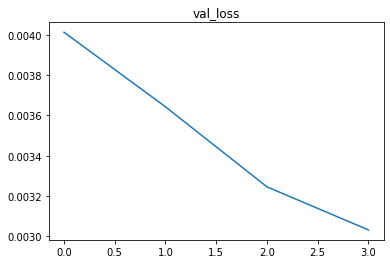

In [15]:
plt.plot(losses_batch['eval'])
plt.title('val_loss')

Text(0.5, 1.0, 'train_batch_loss')

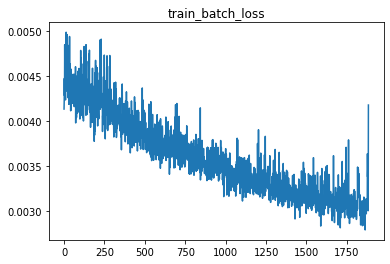

In [16]:
plt.plot(losses_batch['train'][200:])
plt.title('train_batch_loss')

In [22]:
im_true, im_clean, im_noised = evaluation(model, cifar100_test_iterator, losses_batch, get_preds=True)

0.0030829009496131173


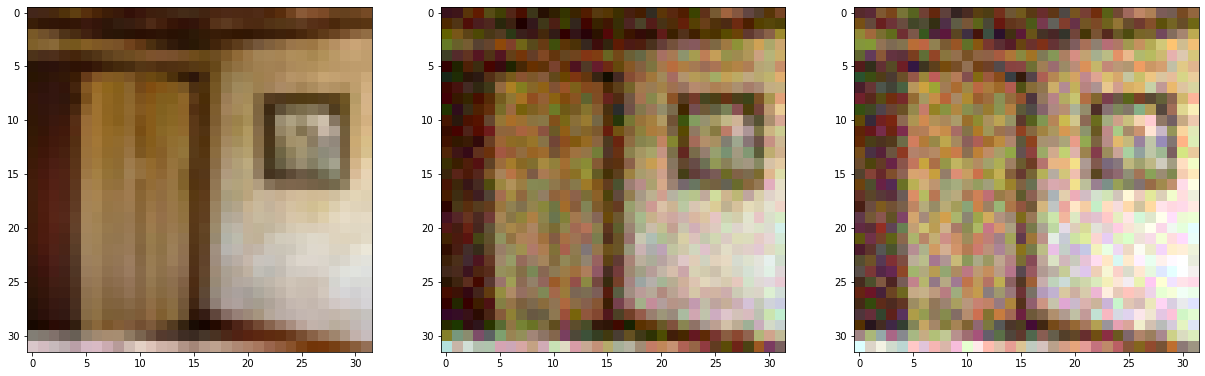

In [30]:
i=14

fig, ax = plt.subplots(1,3, figsize=(21,7))
a = np.moveaxis(im_true[i], (0,1,2), (2,0,1))
b = np.moveaxis(im_clean[i], (0,1,2), (2,0,1))
c = np.moveaxis(im_noised[i], (0,1,2), (2,0,1))

b = np.clip(b, 0, 1)
ax[0].imshow(a)
ax[1].imshow(b)
ax[2].imshow(c)

In [21]:
calculate_psnr(a, b, max_value=1)

24.466544633658188

In [0]:
from skimage.measure import compare_ssim

In [68]:
compare_ssim(a, b, multichannel=True, data_range=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.


0.9621952514434259